## Reflectivity Analysis
This notebook demonstrates fitting the reflectivity of three NDF samples.

In [10]:
import numpy as np
from numpy import random as rand
import matplotlib 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [11]:
N=9 #multiplication factor of mixers (9 in the D-band)
ang_inc_deg=10   #angle of incidence of the source and receiver
pol='TM'     #polarization of the source signal
c = 300.     #speed of light [mm GHz]

In [12]:
# This function takes the raw data from the ROACH and extracts correlated data (i.e. reflectometry measurement)
# The inputs are plate (.txt file), material (.txt file), and N_MULT (an integer) which is the multiplication factor
# for your given setup. For example, a measurement in the W-band (75-125GHz) uses N_MULT = 9. 
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def refl_save(plate,sample,N_MULT):
    
    #The convolution operator models the effect of a linear time-invariant 
    #system on a signal. Another way to think baout this is that convolution 
    #is a measurement of effect of one signal on the other signal.
    
    PLATE = np.loadtxt(plate,skiprows=1)
    SAMPL = np.loadtxt(sample,skiprows=1)
    L_MEAN = 1
    N_INDIV = 2 #specifies appropriate column to read over in the txt file from the ROACH

    line_size = np.size(PLATE[0])
    nsamp =  np.size(PLATE,0) 

    #initialize arrays
    arr_f = np.zeros(nsamp)
    arr_index_diff = np.zeros(nsamp)
    amp_AB=np.zeros(nsamp)
    amp_AA=np.zeros(nsamp)
    amp_BB=np.zeros(nsamp)
    amp_var=np.zeros(nsamp)
    phase=np.zeros(nsamp)
    amp_diff_AB = np.zeros(nsamp)
    amp_diff_var = np.zeros(nsamp)
    amp_diff_phase=np.zeros(nsamp)
    amp_AB_SAMPL = np.zeros(nsamp)
    amp_var_SAMPL = np.zeros(nsamp)
    phase_SAMPL=np.zeros(nsamp)
    amp_AA_SAMPL = np.zeros(nsamp)
    amp_BB_SAMPL= np.zeros(nsamp)
    amp_R_var = np.zeros(nsamp)
    amp_R_cross = np.zeros(nsamp)
    amp_R_cross2 = np.zeros(nsamp)
    amp_R_receive = np.zeros(nsamp)
    amp_p_cross = np.zeros(nsamp)

    # defining indices for reading the .txt file 
    i_AA_begin = int(N_INDIV + (1-1)*(line_size-N_INDIV)/4)
    i_AA_end= int(N_INDIV + (2-1)*(line_size-N_INDIV)/4) -1
    i_BB_begin = int(N_INDIV + (2-1)*(line_size-N_INDIV)/4)
    i_BB_end= int(N_INDIV + (3-1)*(line_size-N_INDIV)/4) -1
    i_AB_begin = int(N_INDIV + (3-1)*(line_size-N_INDIV)/4)
    i_AB_end= int(N_INDIV + (4-1)*(line_size-N_INDIV)/4) -1
    i_phase_begin = int(N_INDIV + (4-1)*(line_size-N_INDIV)/4)
    i_phase_end= int(N_INDIV + (5-1)*(line_size-N_INDIV)/4) -1

    i=int(0)
    replacement_val = 1

    while (i <= nsamp-1):
        #take in raw PLATE
        arr_f[i] = PLATE[i][0]
        #print(arr_f[i])
        index_signal = PLATE[i][1] # use same index singal for both datasets. keep it simple for now. 
        arr_index_diff[i]=int(abs(PLATE[i][1]-SAMPL[i][1]))
        arr_AA = np.array(running_mean(PLATE[i][i_AA_begin : i_AA_end],L_MEAN))
        arr_BB = np.array(running_mean(PLATE[i][i_BB_begin : i_BB_end],L_MEAN))        
        arr_AB = np.array(running_mean(PLATE[i][i_AB_begin : i_AB_end],L_MEAN))
        arr_AA_SAMPL = np.array(running_mean(SAMPL[i][i_AA_begin : i_AA_end],L_MEAN))
        arr_BB_SAMPL = np.array(running_mean(SAMPL[i][i_BB_begin : i_BB_end],L_MEAN))
        arr_AB_SAMPL = np.array(running_mean(SAMPL[i][i_AB_begin : i_AB_end],L_MEAN))

        arr_AA[np.abs(arr_AA)==0.]=replacement_val
        arr_BB[np.abs(arr_BB)==0.]=replacement_val
        arr_AB[np.abs(arr_AB)==0.]=replacement_val
        arr_AA_SAMPL[np.abs(arr_AA_SAMPL)==0.]=replacement_val
        arr_BB_SAMPL[np.abs(arr_BB_SAMPL)==0.]=replacement_val
        arr_AB_SAMPL[np.abs(arr_AB_SAMPL)==0.]=replacement_val

        arr_phase = np.array( PLATE[i][i_phase_begin : i_phase_end] ) 
        arr_phase_SAMPL = np.array( SAMPL[i][i_phase_begin : i_phase_end] ) 
        
        #Convert signal to power. I also divide the sample's cross-correlation (AB) 
        # by its auto-correlation (AA) to remove any noise from the electronics since AA
        # is just the auto-correlation of the receiver. 
        
        arr_p_cross=(arr_phase_SAMPL-arr_phase) # Reflected phase
        arr_R_cross=np.divide((arr_AB_SAMPL/arr_AA_SAMPL),(arr_AB/arr_AA)) # Cross correlated signal
        arr_R_receive=np.divide(arr_BB_SAMPL,arr_BB) # Cross correlated signal at receiver
        arr_R_source =np.divide(arr_AA_SAMPL,arr_AA) # Cross correlated signal at soure

        n_channels = np.size(arr_AB)
        
        amp_AB[i] = np.power(arr_AB[int(n_channels/2)], 1)
        amp_AB_SAMPL[i] = np.power(arr_AB_SAMPL[int(n_channels/2)], 1)
        amp_AA[i] = arr_AA[int(n_channels/2)]
        amp_AA_SAMPL[i] = arr_AA_SAMPL[int(n_channels/2)]
        amp_BB[i] = arr_BB[int(n_channels/2)]
        amp_BB_SAMPL[i] = arr_BB_SAMPL[int(n_channels/2)]
        
        phase[i] = np.remainder(arr_phase[int(n_channels/2)],360.)
        phase_SAMPL[i] = arr_phase_SAMPL[int(n_channels/2)]
        
        amp_p_cross[i] = arr_p_cross[int(n_channels/2)]
        amp_R_cross[i] = arr_R_cross[int(n_channels/2)]
        i = i+1

    ARR_Y = np.power(amp_R_cross[1:],2)
    arr_f = (N_MULT/1000.)*arr_f[1:]

    return arr_f,ARR_Y

In [13]:
def get_transfer_matrix_ang_inc(N_ar,D_ar, freq):

    #this is angle of incidence.  Takes it in in degrees, but we are not savages here
    #convert it to radians, like civilized folk.
    ang_new = ang_inc_deg*np.pi/180.
    
    if pol != 'TM' and pol != 'TE':
        print ("Invalid Polarization.  Please use TE or TM.")

    #Count the number of layers in the structure
    layers = len(D_ar)

    #get angles of incidence for each layer (Snell's law)
    ang_inc_ar = []
    ang_inc_ar.append(ang_new)
    for i in range(1,layers):
        ang_new = np.arcsin(N_ar[i-1].real/N_ar[i].real*np.sin(ang_new))
        ang_inc_ar.append(ang_new)
    ang_inc_ar = np.array(ang_inc_ar)
    
    #Now use this to get the effective thickness for the layers
    D_eff = D_ar/np.cos(ang_inc_ar)

    #Initialize the transfermatrix as the identity, make sure it holds complex numbers
    TM = np.identity(2, dtype=complex)

    #now run throgh the layers and create the transfer matrix
    for i in range(layers-1,0,-1):
      
        tm = np.ones((2,2), dtype = complex)

        if pol == 'TM':
            tm[0,0] = (N_ar[i]/N_ar[i-1] + np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[0,1] = (N_ar[i]/N_ar[i-1] - np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[1,0] = (N_ar[i]/N_ar[i-1] - np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[1,1] = (N_ar[i]/N_ar[i-1] + np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))

        if pol == 'TE':
            tm[0,0] = (1+N_ar[i]/N_ar[i-1]*np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[0,1] = (1-N_ar[i]/N_ar[i-1]*np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[1,0] = (1-N_ar[i]/N_ar[i-1]*np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))
            tm[1,1] = (1+N_ar[i]/N_ar[i-1]*np.cos(ang_inc_ar[i])/np.cos(ang_inc_ar[i-1]))

        tm = 0.5*tm

        #dot this layer into the total transfer matrix
        TM = np.dot(tm,TM)

        #Add propogation matrix
        #this adds the phase delay for the layer
        
        prop = np.identity(2, dtype=complex)
        
        ptx = 2.*np.pi*D_eff[i-1]*freq*N_ar[i-1]/c

        prop[0,0] = np.exp(-1.j*ptx)
        prop[1,1] = np.exp(1.j*ptx)

        TM = np.dot(prop,TM)

    return TM

def find_reflectance(freq_ar,n,ni,d):

    N_ar=[1,n+(ni*1j),1]
    D_ar=[1,d,1]
    
    layers = len(N_ar)      #number of layers

    #convert arrays to numpy arrays
    N_ar = np.array(N_ar,  dtype = complex)   
    D_ar = np.array(D_ar)

    #initialize reflection, transmission arrays
    R = np.zeros(len(freq_ar))
    T = np.zeros(len(freq_ar))

    #start finding reflction and such as a function of frequency
    for i in range(len(freq_ar)):
        freq_i = freq_ar[i]

        #initialize the right traveling wave in the last layer as 1 with zero phase
        E_out = np.array((1. +0.j, 0.0 + 0.j), dtype = complex)

        TM = get_transfer_matrix_ang_inc(N_ar, D_ar,freq_i)
        E_p, E_n = np.dot(TM, E_out)
        
        #find reflection, transmission, and phase coefficients at this frequency
        R[i] = ((E_n/E_p)*(np.conjugate(E_n)/np.conjugate(E_p))).real
        T[i] = ((E_out[0]/E_p)*(E_out[0]/np.conjugate(E_p))).real

    return 10*np.log10(R) #curve fit likes it to only spit out 1 array

In [14]:
p = '../Data_ndf/74-124GHz_0_499_11-18_plate.txt'
h = '../Data_ndf/74-124GHz_0_499_11-18_hdpe.txt'
ndf110 = '../Data_ndf/74-124GHz_0_499_11-18_ndf110.txt'
ndf112 = '../Data_ndf/74-124GHz_0_499_11-18_ndf112.txt'
ndf114 = '../Data_ndf/74-124GHz_0_499_11-18_ndf114.txt'

f,hdpe = refl_save(p,h,N)
f,n110 = refl_save(p,ndf110,N)
f,n112 = refl_save(p,ndf112,N)
f,n114 = refl_save(p,ndf114,N)

## Fitting 

In [15]:
# initial guess passed to fitting funtion: [n_re, n_im, d]
p0_hdpe = [1.5,9e-4,19.]
p0_110 = [1.8,5e-2,7.]
p0_112 = [1.8,4e-2,8.]
p0_114 = [1.8,4e-2,8.]

# bounds on fitting parameters passed to fitting function
bb_hdpe = ([1.2,6e-4,17.],[2,1e-2,22.])
bb_ndf = ([1.4,1e-3,5.],[3,8e-1,9.])

n_popt_HDPE, n_pcov = curve_fit(find_reflectance,f,10*np.log10(hdpe),p0=p0_hdpe, bounds = bb_hdpe)
r_hdpe = find_reflectance(f,*n_popt_HDPE)

n_popt_110, n_pcov = curve_fit(find_reflectance,f,10*np.log10(n110),p0=p0_110, bounds = bb_ndf)
r_n110 = find_reflectance(f,*n_popt_110)

n_popt_112, n_pcov = curve_fit(find_reflectance,f,10*np.log10(n112),p0=p0_112, bounds = bb_ndf)
r_n112 = find_reflectance(f,*n_popt_112)

n_popt_114, n_pcov = curve_fit(find_reflectance,f,10*np.log10(n114),p0=p0_114, bounds = bb_ndf)
r_n114 = find_reflectance(f,*n_popt_114)

## Output of Measurement and Models

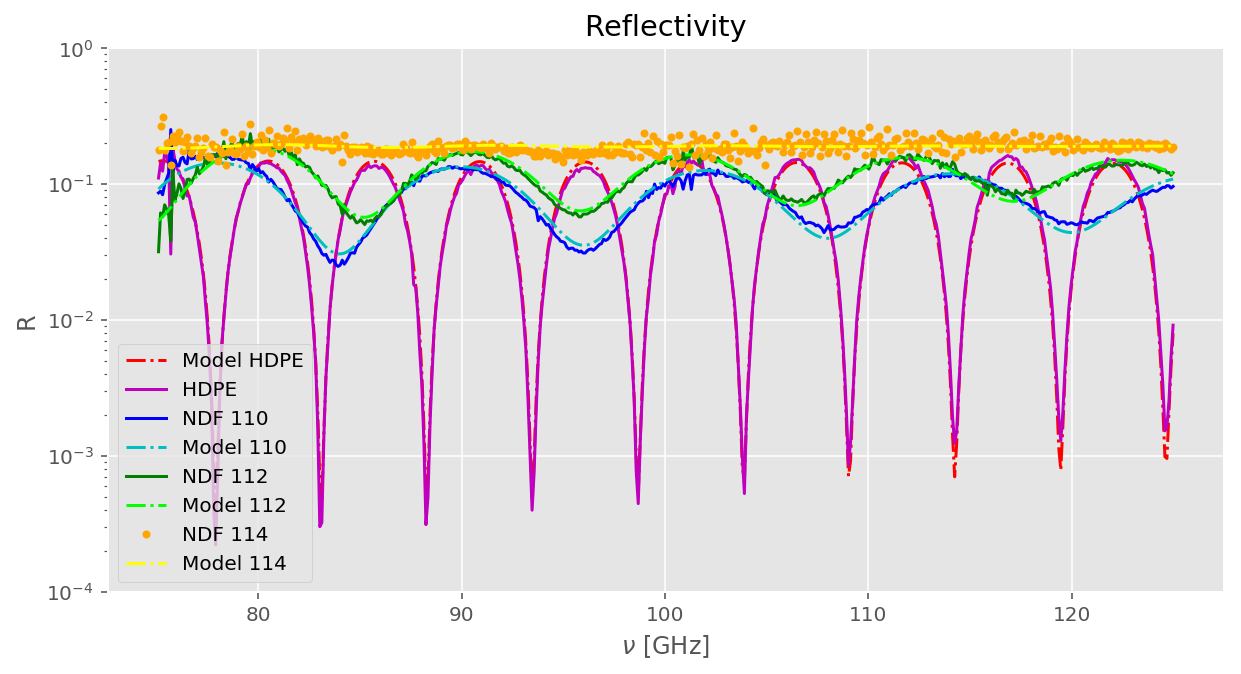

In [16]:
plt.figure(figsize = (10,5))

plt.plot(f,10**(r_hdpe/10),'-.',color = 'r',label = 'Model HDPE')
plt.plot(f,hdpe,color = 'm',label = 'HDPE')

plt.plot(f,n110,color = 'b',label = 'NDF 110')
plt.plot(f,10**(r_n110/10),'-.',color = 'c',label = 'Model 110')

plt.plot(f,n112,color = 'g',label = 'NDF 112')
plt.plot(f,10**(r_n112/10),'-.',color = 'lime',label = 'Model 112')

plt.plot(f,n114,'.',color = 'orange',label = 'NDF 114')
plt.semilogy(f,10**(r_n114/10),'-.',color = 'yellow',label = 'Model 114')

plt.legend()
plt.title('Reflectivity')
plt.ylabel('R')
plt.xlabel(r'$\nu$ [GHz]')

plt.ylim(1e-4,1)
plt.show()

In [17]:
print("HDPE: Thickness {:.2f} mm, Index of refraction {:.3f} ± {:.3f}".format(n_popt_HDPE[2],n_popt_HDPE[0],n_popt_HDPE[1]))
print("NDF 110: Thickness {:.2f} mm, Index of refraction {:.3f} ± {:.3f}".format(n_popt_110[2],n_popt_110[0],n_popt_110[1]))
print("NDF 112: Thickness {:.2f} mm, Index of refraction {:.3f} ± {:.3f}".format(n_popt_112[2],n_popt_112[0],n_popt_112[1]))
print("NDF 114: Thickness {:.2f} mm, Index of refraction {:.3f} ± {:.3f}".format(n_popt_114[2],n_popt_114[0],n_popt_114[1]))

HDPE: Thickness 18.61 mm, Index of refraction 1.542 ± 0.001
NDF 110: Thickness 6.98 mm, Index of refraction 1.782 ± 0.039
NDF 112: Thickness 6.94 mm, Index of refraction 2.023 ± 0.047
NDF 114: Thickness 5.42 mm, Index of refraction 2.555 ± 0.220
